# Neural Storyteller – Image Captioning with Seq2Seq

**Course:** Generative AI (AI4009)   
**Assignment:** No.1  
**University:** National University of Computer and Emerging Sciences   
**Group:** 22F-3442,22F-3866   
**Section:** 8D

## Part 1: Feature Extraction Pipeline

Extract 2048-dimensional feature vectors from Flickr30k images using a pre-trained **ResNet50**.

In [1]:
import os
import re
import json
import pickle
import random
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import gradio as gr
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchvision import models, transforms


In [2]:

def find_image_dir():
    """Find the Flickr30k image directory"""
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None


IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory.")


class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50 (remove classification layer)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
print(f"Total images to process: {len(dataset)}")

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"\nSuccess! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Total images to process: 31783


Extracting Features: 100%|██████████| 249/249 [02:00<00:00,  2.07it/s]



Success! 31783 images processed and saved to flickr30k_features.pkl


---
## Part 2: Vocabulary & Text Pre-Processing

Load and preprocess `captions.txt` from the Flickr30k dataset:
- Expand contractions, remove punctuation & URLs
- Add `<start>` and `<end>` tokens
- Build a vocabulary with frequency thresholding
- Create train/val/test splits and PyTorch DataLoaders

### 2.1 Caption Preprocessing

In [3]:

class SimplePreprocessor:
    """One-class solution for caption preprocessing"""

    CONTRACTIONS = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot",
        "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "isn't": "is not", "it's": "it is", "that's": "that is",
        "won't": "will not", "wouldn't": "would not", "you're": "you are",
    }

    def __init__(self):
        self.captions_file = self._find_captions_file()

    def _find_captions_file(self):
        search_paths = ['/kaggle/input', './data', '../data', '.']
        for path in search_paths:
            if os.path.exists(path):
                for root, dirs, files in os.walk(path):
                    for file in files:
                        if 'caption' in file.lower() and file.endswith('.txt'):
                            return os.path.join(root, file)
        raise FileNotFoundError("Cannot find captions.txt. Check /kaggle/input or ./data")

    def preprocess(self, caption: str) -> str:
        caption = caption.lower()
        for contraction, expansion in self.CONTRACTIONS.items():
            caption = caption.replace(contraction, expansion)
        caption = re.sub(r'http\S+|www\S+', '', caption)
        caption = re.sub(r'[^\w\s]', '', caption)
        caption = ' '.join(caption.split())
        caption = '<start> ' + caption + ' <end>'
        return caption

    def run(self):
        print("\n" + "=" * 60)
        print("PREPROCESSING FLICKR30K CAPTIONS")
        print("=" * 60)

        print("\n[1] Loading captions...")
        df = pd.read_csv(self.captions_file)
        df.columns = df.columns.str.strip()

        image_col = next((c for c in df.columns if 'image' in c.lower()), df.columns[0])
        caption_col = next((c for c in df.columns if 'caption' in c.lower()), df.columns[1])

        image_to_captions = defaultdict(list)
        for _, row in df.iterrows():
            img = str(row[image_col]).strip()
            cap = str(row[caption_col]).strip()
            image_to_captions[img].append(cap)

        print(f"Loaded {len(image_to_captions)} images, {len(df)} captions")

        print("\n[2] Preprocessing...")
        image_to_processed = {}
        for img, caps in image_to_captions.items():
            image_to_processed[img] = [self.preprocess(c) for c in caps]
        print(f"Processed {len(df)} captions")

        print("\n[3] Examples:")
        for img, caps in list(image_to_processed.items())[:2]:
            print(f"\n  Image: {img}")
            for cap in caps[:2]:
                print(f"    - {cap}")

        print("\n[4] Statistics:")
        original_lengths = [len(c.split()) for caps in image_to_captions.values() for c in caps]
        processed_lengths = [len(c.split()) for caps in image_to_processed.values() for c in caps]
        print(f"  Original avg length: {np.mean(original_lengths):.2f} words")
        print(f"  Processed avg length: {np.mean(processed_lengths):.2f} words")

        print("\n[5] Saving...")
        pickle.dump({
            'image_to_captions': dict(image_to_captions),
            'image_to_processed': image_to_processed,
        }, open('captions.pkl', 'wb'))
        print("  captions.pkl saved")

        json.dump({
            'total_images': len(image_to_processed),
            'total_captions': len(df),
            'avg_original_length': float(np.mean(original_lengths)),
            'avg_processed_length': float(np.mean(processed_lengths)),
        }, open('stats.json', 'w'), indent=2)
        print("  stats.json saved")

        print("\n" + "=" * 60)
        print("DONE! Ready to build vocabulary.")
        print("=" * 60)
        return image_to_processed


preprocessor = SimplePreprocessor()
image_to_processed = preprocessor.run()


PREPROCESSING FLICKR30K CAPTIONS

[1] Loading captions...
Loaded 31783 images, 158915 captions

[2] Preprocessing...
Processed 158915 captions

[3] Examples:

  Image: 1000092795.jpg
    - <start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
    - <start> two young white males are outside near many bushes <end>

  Image: 10002456.jpg
    - <start> several men in hard hats are operating a giant pulley system <end>
    - <start> workers look down from up above on a piece of equipment <end>

[4] Statistics:
  Original avg length: 13.39 words
  Processed avg length: 14.26 words

[5] Saving...
  captions.pkl saved
  stats.json saved

DONE! Ready to build vocabulary.


### 2.2 Vocabulary Building & DataLoaders

In [4]:

class Vocabulary:

    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.word_freq = Counter()

    def build_vocabulary(self, captions_list):
        for caption in captions_list:
            self.word_freq.update(caption.split())
        idx = 4
        for word, freq in self.word_freq.most_common():
            if freq >= self.freq_threshold and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        print(f"Vocabulary: {len(self.word2idx)} tokens")

    def encode(self, caption, add_tokens=True):
        tokens = []
        if add_tokens:
            tokens.append(self.word2idx['<start>'])
        for word in caption.split():
            tokens.append(self.word2idx.get(word, self.word2idx['<unk>']))
        if add_tokens:
            tokens.append(self.word2idx['<end>'])
        return tokens

    def __len__(self):
        return len(self.word2idx)


class CaptionDataset(Dataset):

    def __init__(self, image_names, image_to_captions, vocab):
        self.data = []
        self.vocab = vocab
        for img_name in image_names:
            if img_name in image_to_captions:
                for caption in image_to_captions[img_name]:
                    self.data.append((img_name, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        caption_indices = self.vocab.encode(caption)
        return img_name, torch.LongTensor(caption_indices)


def collate_fn(batch):
    image_names, captions = zip(*batch)
    lengths = [len(cap) for cap in captions]
    sorted_indices = sorted(range(len(lengths)), key=lambda i: lengths[i], reverse=True)
    image_names = [image_names[i] for i in sorted_indices]
    captions = [captions[i] for i in sorted_indices]
    lengths = sorted(lengths, reverse=True)
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)
    return image_names, captions_padded, torch.LongTensor(lengths)


print("\n" + "=" * 60)
print("VOCABULARY + DATASET BUILDER")
print("=" * 60)

print("\n[1] Loading captions...")
data = pickle.load(open('captions.pkl', 'rb'))
image_to_captions = data['image_to_processed']
print(f"{len(image_to_captions)} images loaded")

print("\n[2] Building vocabulary...")
all_captions = [cap for caps in image_to_captions.values() for cap in caps]
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(all_captions)

print("\n[3] Splitting data...")
all_images = list(image_to_captions.keys())
random.shuffle(all_images)
train_size = int(0.8 * len(all_images))
val_size = int(0.1 * len(all_images))
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]
print(f"  Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")

print("\n[4] Creating datasets...")
train_dataset = CaptionDataset(train_images, image_to_captions, vocab)
val_dataset = CaptionDataset(val_images, image_to_captions, vocab)
test_dataset = CaptionDataset(test_images, image_to_captions, vocab)

print("\n[5] Creating dataloaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print(f"  Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)} batches")

print("\n[6] Testing dataloader...")
batch = next(iter(train_loader))
image_names, captions, lengths = batch
print(f"  Batch size: {len(image_names)} | Captions shape: {captions.shape}")

print("\n[7] Saving...")
pickle.dump(vocab.__dict__, open('vocab.pkl', 'wb'))
pickle.dump({'train_images': train_images, 'val_images': val_images, 'test_images': test_images}, open('splits.pkl', 'wb'))
print("Saved: vocab.pkl, splits.pkl")

print("\n" + "=" * 60)
print("DONE! Ready to build the model.")
print("=" * 60)


VOCABULARY + DATASET BUILDER

[1] Loading captions...
31783 images loaded

[2] Building vocabulary...
Vocabulary: 7727 tokens

[3] Splitting data...
  Train: 25426 | Val: 3178 | Test: 3179

[4] Creating datasets...

[5] Creating dataloaders...
  Train: 3973 | Val: 497 | Test: 497 batches

[6] Testing dataloader...
  Batch size: 32 | Captions shape: torch.Size([32, 28])

[7] Saving...
Saved: vocab.pkl, splits.pkl

DONE! Ready to build the model.


---
## Part 3: The Seq2Seq Architecture

Build the Encoder-Decoder model with **Bahdanau Attention**:

- **Encoder:** A Linear layer projecting the 2048-dim cached ResNet50 vector into `hidden_size` (512).
- **Decoder:** An LSTM with attention mechanism.
  - *Input:* Word embeddings concatenated with attention context
  - *Initial Hidden State:* Derived from the Encoder output
  - *Output:* Linear layer mapped to `vocab_size`

In [5]:

class Encoder(nn.Module):

    def __init__(self, feature_size=2048, hidden_size=512, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, features):
        x = self.fc(features)
        x = self.layer_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x


class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_encoder = nn.Linear(encoder_dim, attention_dim)
        self.W_decoder = nn.Linear(decoder_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden, encoder_proj=None):
        if encoder_proj is None:
            encoder_proj = self.W_encoder(encoder_out)
        decoder_proj = self.W_decoder(decoder_hidden).unsqueeze(1)
        scores = self.V(torch.tanh(encoder_proj + decoder_proj)).squeeze(2)
        alpha = F.softmax(scores, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha


class Decoder(nn.Module):

    def __init__(self, vocab_size, embed_size=256, hidden_size=512,
                 num_layers=2, dropout=0.5):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.attention = BahdanauAttention(hidden_size, hidden_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size + hidden_size, vocab_size)
        self.gate = nn.Linear(hidden_size, hidden_size)
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def _init_hidden(self, encoder_out):
        h0 = torch.tanh(self.init_h(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.tanh(self.init_c(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h0, c0

    def forward(self, encoder_out, captions, lengths):

        batch_size = encoder_out.size(0)
        max_len = captions.size(1) - 1
        embeddings = self.embedding(captions[:, :-1])
        embeddings = self.dropout(embeddings)
        h, c = self._init_hidden(encoder_out)

        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)

        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_out.device)
        for t in range(max_len):
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            gate_val = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate_val * context
            lstm_input = torch.cat([embeddings[:, t, :], gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            outputs[:, t, :] = output
        return outputs

    def greedy_search(self, encoder_out, max_len=20):
        batch_size = encoder_out.size(0)
        sampled_ids = []
        h, c = self._init_hidden(encoder_out)
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)
        current_input = torch.ones(batch_size, dtype=torch.long).to(encoder_out.device)

        for t in range(max_len):
            embeddings = self.embedding(current_input)
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            gate_val = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate_val * context
            lstm_input = torch.cat([embeddings, gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            output = self.fc(torch.cat([lstm_out.squeeze(1), context], dim=1))
            predicted = output.argmax(1)
            sampled_ids.append(predicted.cpu().numpy())
            current_input = predicted

        return np.column_stack(sampled_ids)

    def beam_search(self, encoder_out, beam_width=5, max_len=20, start_token=1, end_token=2):
        device = encoder_out.device
        h, c = self._init_hidden(encoder_out)
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)

        beams = [(0.0, [start_token], h, c)]
        completed = []

        for step in range(max_len):
            candidates = []
            for log_prob, seq, h_beam, c_beam in beams:
                last_token = seq[-1]
                if last_token == end_token:
                    completed.append((log_prob, seq))
                    continue

                inp = torch.LongTensor([last_token]).to(device)
                emb = self.embedding(inp)
                context, _ = self.attention(encoder_out_expanded, h_beam[-1], encoder_proj)
                gate_val = torch.sigmoid(self.gate(h_beam[-1]))
                gated_context = gate_val * context
                lstm_input = torch.cat([emb, gated_context], dim=1).unsqueeze(1)
                lstm_out, (h_new, c_new) = self.lstm(lstm_input, (h_beam, c_beam))
                logits = self.fc(torch.cat([lstm_out.squeeze(1), context], dim=1))
                log_probs = F.log_softmax(logits, dim=1).squeeze(0)
                topk_probs, topk_ids = log_probs.topk(beam_width)

                for i in range(beam_width):
                    new_prob = log_prob + topk_probs[i].item()
                    new_seq = seq + [topk_ids[i].item()]
                    candidates.append((new_prob, new_seq, h_new.clone(), c_new.clone()))

            if not candidates:
                break
            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_width]

        for log_prob, seq, _, _ in beams:
            completed.append((log_prob, seq))

        if not completed:
            return [start_token]

        completed.sort(key=lambda x: x[0] / len(x[1]), reverse=True)
        return completed[0][1]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_SIZE, EMBED_SIZE, NUM_LAYERS, DROPOUT = 512, 256, 2, 0.5
VOCAB_SIZE = 10000

encoder = Encoder(feature_size=2048, hidden_size=HIDDEN_SIZE, dropout=DROPOUT).to(device)
decoder = Decoder(vocab_size=VOCAB_SIZE, embed_size=EMBED_SIZE,
                  hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)

enc_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
dec_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"Encoder params: {enc_params:,} | Decoder params: {dec_params:,} | Total: {enc_params + dec_params:,}")

test_feats = torch.randn(4, 2048).to(device)
test_caps = torch.randint(0, VOCAB_SIZE, (4, 20)).to(device)
enc_out = encoder(test_feats)
dec_out = decoder(enc_out, test_caps, None)
print(f"Input: {test_feats.shape} -> Encoded: {enc_out.shape} -> Output: {dec_out.shape}")
print("Model architecture verified!")

Encoder params: 1,050,112 | Decoder params: 18,850,577 | Total: 19,900,689
Input: torch.Size([4, 2048]) -> Encoded: torch.Size([4, 512]) -> Output: torch.Size([4, 19, 10000])
Model architecture verified!


---
## Part 4: Training & Inference

- **Loss Function:** CrossEntropyLoss with `ignore_index=0` (padding token)
- **Optimizer:** Adam with learning rate scheduling
- **Inference:** Greedy Search and Beam Search

### 4.1 Training Loop

In [7]:

BATCH_SIZE = 128
LEARNING_RATE = 3e-4
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ImageCaptionDataset(Dataset):
    def __init__(self, image_names, features_dict, image_to_captions, vocab):
        self.image_names = image_names
        self.features_dict = features_dict
        self.image_to_captions = image_to_captions
        self.vocab = vocab

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        captions = self.image_to_captions[img_name]
        caption = random.choice(captions)

        tokens = [self.vocab.word2idx.get('<start>', 1)]
        for word in caption.split():
            tokens.append(self.vocab.word2idx.get(word, self.vocab.word2idx.get('<unk>', 3)))
        tokens.append(self.vocab.word2idx.get('<end>', 2))

        features = torch.FloatTensor(self.features_dict[img_name])
        return torch.LongTensor(tokens), features


def collate_fn(batch):
    captions, features = zip(*batch)
    max_len = max(len(c) for c in captions)
    padded = []
    for cap in captions:
        if len(cap) < max_len:
            padded.append(torch.cat([cap, torch.zeros(max_len - len(cap), dtype=cap.dtype)]))
        else:
            padded.append(cap)
    return torch.stack(padded), torch.stack(features)


def train_epoch(encoder, decoder, train_loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()
    total_loss, total_correct, total_tokens = 0.0, 0, 0
    pbar = tqdm(train_loader, desc="Training")

    for captions, features in pbar:
        captions, features = captions.to(device), features.to(device)
        encoded = encoder(features)
        outputs = decoder(encoded, captions, None)

        out_flat = outputs.reshape(-1, outputs.shape[2])
        tgt_flat = captions[:, 1:].reshape(-1)
        loss = criterion(out_flat, tgt_flat)

        preds = out_flat.argmax(dim=1)
        mask = tgt_flat != 0
        correct = (preds == tgt_flat) & mask
        total_correct += correct.sum().item()
        total_tokens += mask.sum().item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 5.0)
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct.sum().item() / max(mask.sum().item(), 1) * 100:.1f}%'})

    return total_loss / len(train_loader), total_correct / max(total_tokens, 1) * 100


def validate(encoder, decoder, val_loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss, total_correct, total_tokens = 0.0, 0, 0

    with torch.no_grad():
        for captions, features in tqdm(val_loader, desc="Validation"):
            captions, features = captions.to(device), features.to(device)
            encoded = encoder(features)
            outputs = decoder(encoded, captions, None)

            out_flat = outputs.reshape(-1, outputs.shape[2])
            tgt_flat = captions[:, 1:].reshape(-1)
            loss = criterion(out_flat, tgt_flat)
            total_loss += loss.item()

            preds = out_flat.argmax(dim=1)
            mask = tgt_flat != 0
            correct = (preds == tgt_flat) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

    return total_loss / len(val_loader), total_correct / max(total_tokens, 1) * 100


print("TRAINING WITH REAL IMAGE FEATURES")

print("\n[1] Loading vocabulary...")
vocab_data = pickle.load(open('vocab.pkl', 'rb'))
class Vocab: pass
vocab = Vocab()
vocab.word2idx = vocab_data['word2idx']
vocab.idx2word = vocab_data['idx2word']
vocab_size = len(vocab_data['word2idx'])
print(f"Vocab size: {vocab_size}")

print("[2] Loading captions...")
with open('captions.pkl', 'rb') as f:
    data = pickle.load(f)
image_to_captions = data['image_to_processed']
print(f"Loaded {len(image_to_captions)} images")

print("[3] Loading image features...")
with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)
print(f"Loaded {len(features_dict)} image features")

print("[4] Splitting data...")
all_images = list(image_to_captions.keys())
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]
print(f"Train: {len(train_images)} | Val: {len(val_images)}")

print("[5] Creating datasets...")
train_dataset = ImageCaptionDataset(train_images, features_dict, image_to_captions, vocab)
val_dataset = ImageCaptionDataset(val_images, features_dict, image_to_captions, vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Train: {len(train_loader)} batches | Val: {len(val_loader)} batches")

print("[6] Initializing models...")
encoder = Encoder(feature_size=2048, hidden_size=512, dropout=0.5).to(DEVICE)
decoder = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("\n[7] Starting training...\n")
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'=' * 70}\nEpoch {epoch + 1}/{NUM_EPOCHS}\n{'=' * 70}")

    t_loss, t_acc = train_epoch(encoder, decoder, train_loader, criterion, optimizer, DEVICE)
    v_loss, v_acc = validate(encoder, decoder, val_loader, criterion, DEVICE)

    train_losses.append(t_loss); val_losses.append(v_loss)
    train_accs.append(t_acc); val_accs.append(v_acc)
    scheduler.step(v_loss)

    print(f"\n  Train Loss: {t_loss:.4f} | Acc: {t_acc:.2f}%")
    print(f"  Val Loss:   {v_loss:.4f} | Acc: {v_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': t_loss, 'val_loss': v_loss,
            'train_acc': t_acc, 'val_acc': v_acc,
        }, 'best_model.pth')
        print("  Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print(f"Early stopping at epoch {epoch + 1}!")
            break

with open('training_history.json', 'w') as f:
    json.dump({'train_loss': train_losses, 'val_loss': val_losses,
               'train_acc': train_accs, 'val_acc': val_accs}, f, indent=2)

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")


TRAINING WITH REAL IMAGE FEATURES

[1] Loading vocabulary...
Vocab size: 7727
[2] Loading captions...
Loaded 31783 images
[3] Loading image features...
Loaded 31783 image features
[4] Splitting data...
Train: 25426 | Val: 6357
[5] Creating datasets...
Train: 199 batches | Val: 50 batches
[6] Initializing models...

[7] Starting training...


Epoch 1/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]



  Train Loss: 5.4357 | Acc: 27.81%
  Val Loss:   4.7852 | Acc: 33.80%
  LR: 0.000300
  Best model saved!

Epoch 2/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]



  Train Loss: 4.6742 | Acc: 34.66%
  Val Loss:   4.3969 | Acc: 37.61%
  LR: 0.000300
  Best model saved!

Epoch 3/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]



  Train Loss: 4.4223 | Acc: 36.87%
  Val Loss:   4.2240 | Acc: 38.99%
  LR: 0.000300
  Best model saved!

Epoch 4/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]



  Train Loss: 4.2888 | Acc: 38.04%
  Val Loss:   4.1013 | Acc: 40.00%
  LR: 0.000300
  Best model saved!

Epoch 5/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.33it/s]



  Train Loss: 4.2092 | Acc: 38.78%
  Val Loss:   4.0473 | Acc: 40.60%
  LR: 0.000300
  Best model saved!

Epoch 6/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.38it/s]



  Train Loss: 4.1389 | Acc: 39.56%
  Val Loss:   4.0012 | Acc: 41.19%
  LR: 0.000300
  Best model saved!

Epoch 7/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]



  Train Loss: 4.0931 | Acc: 39.99%
  Val Loss:   3.9542 | Acc: 41.65%
  LR: 0.000300
  Best model saved!

Epoch 8/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]



  Train Loss: 4.0611 | Acc: 40.30%
  Val Loss:   3.9326 | Acc: 41.84%
  LR: 0.000300
  Best model saved!

Epoch 9/20


Validation: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s]



  Train Loss: 4.0243 | Acc: 40.64%
  Val Loss:   3.9021 | Acc: 42.30%
  LR: 0.000300
  Best model saved!

Epoch 10/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.45it/s]



  Train Loss: 3.9991 | Acc: 40.91%
  Val Loss:   3.8768 | Acc: 42.55%
  LR: 0.000300
  Best model saved!

Epoch 11/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]



  Train Loss: 3.9717 | Acc: 41.19%
  Val Loss:   3.8502 | Acc: 42.81%
  LR: 0.000300
  Best model saved!

Epoch 12/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.46it/s]



  Train Loss: 3.9555 | Acc: 41.41%
  Val Loss:   3.8447 | Acc: 42.83%
  LR: 0.000300
  Best model saved!

Epoch 13/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]



  Train Loss: 3.9401 | Acc: 41.50%
  Val Loss:   3.8295 | Acc: 43.21%
  LR: 0.000300
  Best model saved!

Epoch 14/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]



  Train Loss: 3.9228 | Acc: 41.79%
  Val Loss:   3.7995 | Acc: 43.49%
  LR: 0.000300
  Best model saved!

Epoch 15/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]



  Train Loss: 3.9044 | Acc: 41.99%
  Val Loss:   3.8139 | Acc: 43.19%
  LR: 0.000300

Epoch 16/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.30it/s]



  Train Loss: 3.9017 | Acc: 41.94%
  Val Loss:   3.8016 | Acc: 43.36%
  LR: 0.000300

Epoch 17/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]



  Train Loss: 3.8835 | Acc: 42.17%
  Val Loss:   3.8002 | Acc: 43.27%
  LR: 0.000150

Epoch 18/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]



  Train Loss: 3.8612 | Acc: 42.35%
  Val Loss:   3.7687 | Acc: 43.84%
  LR: 0.000150
  Best model saved!

Epoch 19/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.73it/s]



  Train Loss: 3.8510 | Acc: 42.62%
  Val Loss:   3.7770 | Acc: 43.61%
  LR: 0.000150

Epoch 20/20


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.70it/s]



  Train Loss: 3.8432 | Acc: 42.62%
  Val Loss:   3.7648 | Acc: 43.76%
  LR: 0.000150
  Best model saved!

Training complete! Best val loss: 3.7648


---
## Deliverables

### Deliverable 1: Caption Examples — Greedy Search & Beam Search

Display 5 random test images with ground truth captions and model-generated captions using both Greedy and Beam Search decoding.

Best model loaded
[Sample 1] 2232822316.jpg
  Ground Truth:  a woman dressed in a light yellow tank top white pants and sunglasses looks to her right as she is drinking a bottle of water
  Greedy Search: a woman in a white shirt is standing on a sidewalk
  Beam Search:   a woman in a white shirt is standing in front of a crowd of people

[Sample 2] 623052035.jpg
  Ground Truth:  a young woman wearing a hat speaks to children in a classroom
  Greedy Search: a group of people are sitting in a classroom
  Beam Search:   a group of people are sitting at a table

[Sample 3] 4328445479.jpg
  Ground Truth:  several kids in what seems to be a classroom working on a problem together or potentially giving a presentation
  Greedy Search: a group of people are standing in front of a building
  Beam Search:   a group of people are standing in front of a building

[Sample 4] 5737434301.jpg
  Ground Truth:  many people standing around a silver car with the hood raised while a young girl in a yellow s

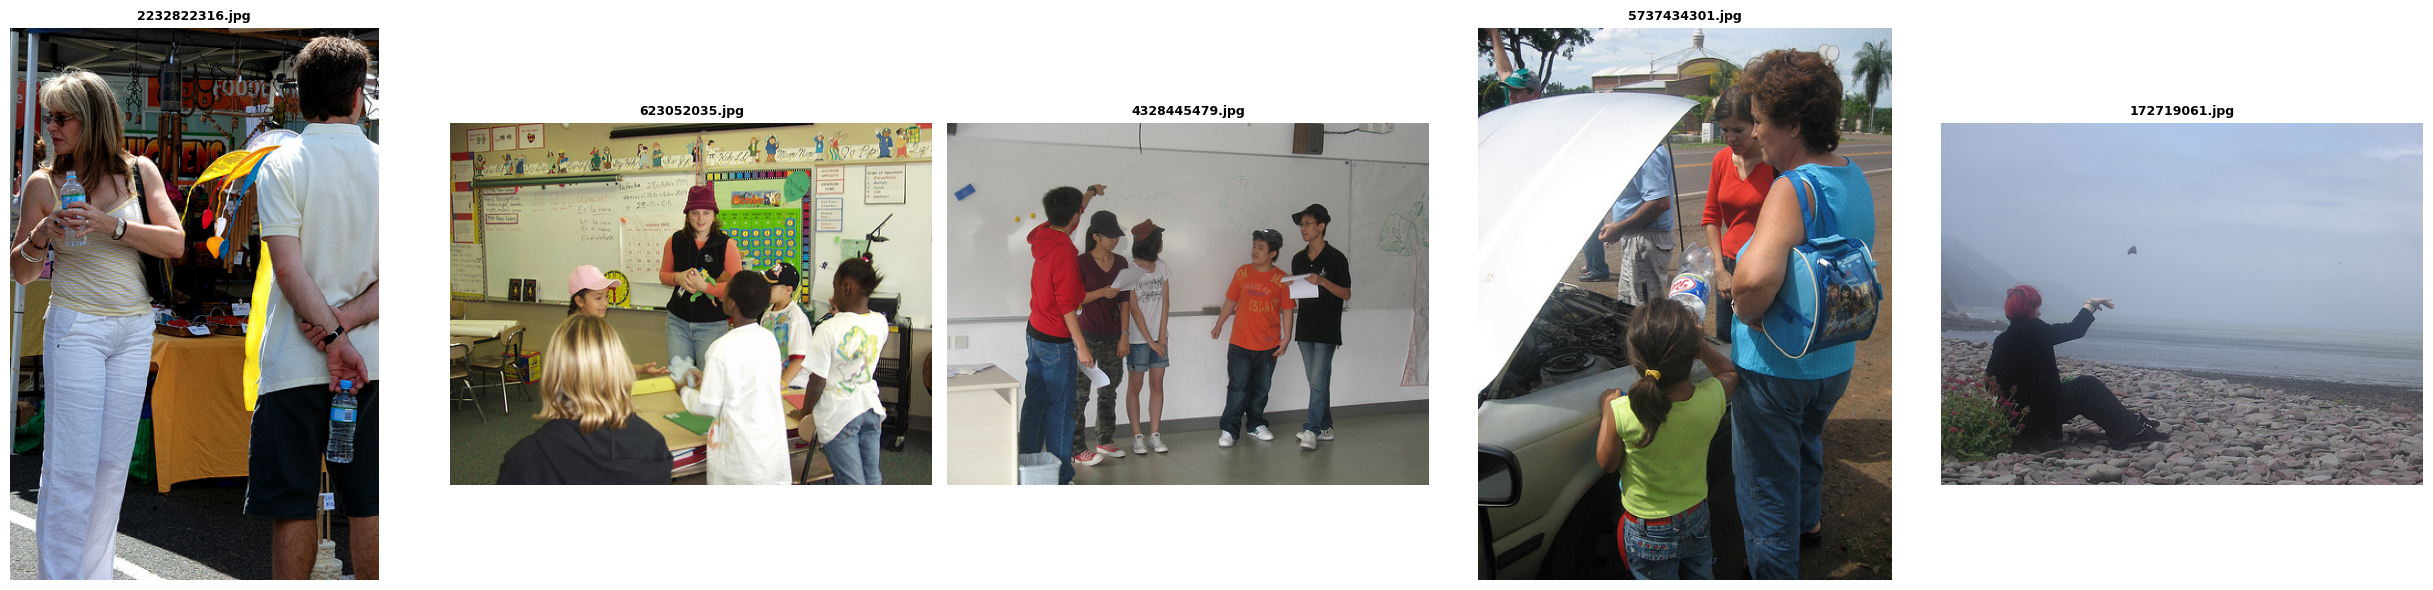

Caption examples saved to 'caption_examples.png'


In [8]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_data = pickle.load(open('vocab.pkl', 'rb'))
word2idx = vocab_data['word2idx']
idx2word = vocab_data.get('idx2word', {v: k for k, v in word2idx.items()})
vocab_size = len(word2idx)

with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)
with open('captions.pkl', 'rb') as f:
    caption_data = pickle.load(f)
image_to_captions = caption_data['image_to_processed']

encoder = Encoder(feature_size=2048, hidden_size=512, dropout=0.5).to(DEVICE)
decoder = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5).to(DEVICE)
ckpt = torch.load('best_model.pth', map_location=DEVICE)
encoder.load_state_dict(ckpt['encoder_state_dict'])
decoder.load_state_dict(ckpt['decoder_state_dict'])
encoder.eval()
decoder.eval()
print("Best model loaded")


def ids_to_caption(token_ids):
    words = []
    for wid in token_ids:
        word = idx2word.get(int(wid), '<unk>')
        if word == '<end>': break
        if word not in ['<start>', '<pad>']: words.append(word)
    return ' '.join(words)


def generate_greedy(img_name):
    feats = torch.FloatTensor(features_dict[img_name]).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        enc = encoder(feats)
        ids = decoder.greedy_search(enc, max_len=20)
    return ids_to_caption(ids[0])


def generate_beam(img_name, beam_width=5):
    feats = torch.FloatTensor(features_dict[img_name]).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        enc = encoder(feats)
        seq = decoder.beam_search(enc, beam_width=beam_width, max_len=20,
                                   start_token=word2idx.get('<start>', 1),
                                   end_token=word2idx.get('<end>', 2))
    return ids_to_caption(seq)


IMAGE_DIR = None
for root, dirs, files in os.walk('/kaggle/input'):
    if len([f for f in files if f.endswith('.jpg')]) > 1000:
        IMAGE_DIR = root
        break

valid_images = [img for img in image_to_captions if img in features_dict]
samples = random.sample(valid_images, 5)

fig, axes = plt.subplots(1, 5, figsize=(25, 6))
for i, img_name in enumerate(samples):
    if IMAGE_DIR:
        img_path = os.path.join(IMAGE_DIR, img_name)
        if os.path.exists(img_path):
            axes[i].imshow(Image.open(img_path).convert('RGB'))
    axes[i].set_title(img_name[:18], fontsize=9, fontweight='bold')
    axes[i].axis('off')

    gt = image_to_captions[img_name][0].replace('<start>', '').replace('<end>', '').strip()
    greedy = generate_greedy(img_name)
    beam = generate_beam(img_name, beam_width=5)

    print(f"[Sample {i + 1}] {img_name}")
    print(f"  Ground Truth:  {gt}")
    print(f"  Greedy Search: {greedy}")
    print(f"  Beam Search:   {beam}\n")

plt.tight_layout()
plt.savefig('caption_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print("Caption examples saved to 'caption_examples.png'")

### Deliverable 2: Loss Curve

Plot training and validation loss (and accuracy) over epochs.

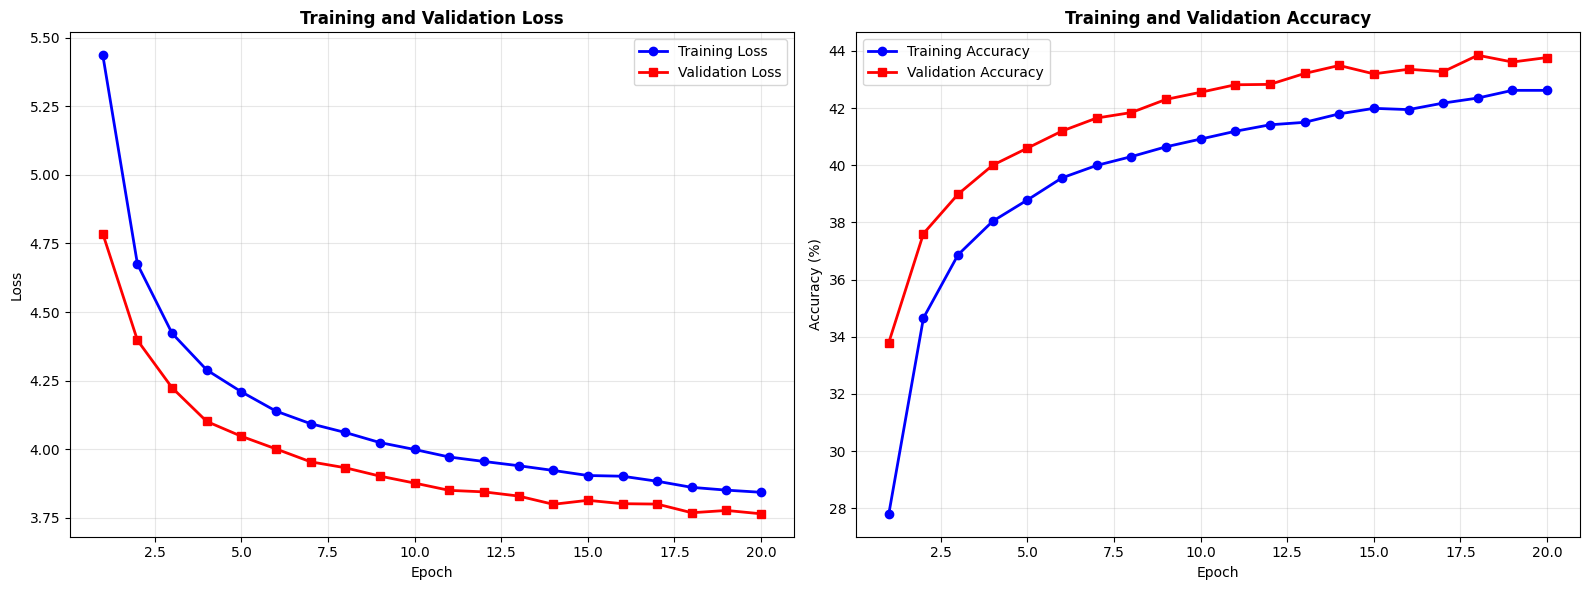

Final Train Loss: 3.8432 | Val Loss: 3.7648
Best Val Loss: 3.7648 (Epoch 20)
Curves saved to 'loss_accuracy_curve.png'


In [9]:

with open('training_history.json', 'r') as f:
    history = json.load(f)

train_losses = history['train_loss']
val_losses = history['val_loss']
train_accs = history['train_acc']
val_accs = history['val_acc']
epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, val_accs, 'r-s', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_accuracy_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
print(f"Best Val Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
print("Curves saved to 'loss_accuracy_curve.png'")

### Deliverable 3: Quantitative Evaluation

Compute **BLEU-4**, token-level **Precision**, **Recall**, and **F1-Score** on a test subset.

In [10]:

def calculate_token_metrics(references_list, hypotheses_list):
    """Calculate token-level precision, recall, F1"""
    tp, tr, tf, cnt = 0, 0, 0, 0
    for refs, hyp in zip(references_list, hypotheses_list):
        ref_tokens = refs[0]
        if not hyp or not ref_tokens: continue
        rc, hc = Counter(ref_tokens), Counter(hyp)
        overlap = sum((rc & hc).values())
        p = overlap / len(hyp) if hyp else 0
        r = overlap / len(ref_tokens) if ref_tokens else 0
        f = 2 * p * r / (p + r) if (p + r) > 0 else 0
        tp += p; tr += r; tf += f; cnt += 1
    return (tp / cnt if cnt else 0, tr / cnt if cnt else 0, tf / cnt if cnt else 0)


print("[1] Generating captions on test set...")
test_imgs = [img for img in list(features_dict.keys())[:500] if img in image_to_captions]
gen_caps, ref_caps = {}, {}

for img in tqdm(test_imgs, desc="Generating"):
    gen_caps[img] = generate_greedy(img).split()
    ref_caps[img] = [c.replace('<start>', '').replace('<end>', '').strip().split()
                     for c in image_to_captions[img]]
print(f"Generated {len(gen_caps)} captions")

refs_list = [ref_caps[img] for img in gen_caps if img in ref_caps]
hyps_list = [gen_caps[img] for img in gen_caps if img in ref_caps]

smoother = SmoothingFunction().method1
bleu1 = corpus_bleu(refs_list, hyps_list, weights=(1, 0, 0, 0), smoothing_function=smoother)
bleu2 = corpus_bleu(refs_list, hyps_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoother)
bleu3 = corpus_bleu(refs_list, hyps_list, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoother)
bleu4 = corpus_bleu(refs_list, hyps_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother)
prec, rec, f1 = calculate_token_metrics(refs_list, hyps_list)

print("\n" + "=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)
print(f"\nBLEU Scores:")
print(f"  BLEU-1: {bleu1:.4f}")
print(f"  BLEU-2: {bleu2:.4f}")
print(f"  BLEU-3: {bleu3:.4f}")
print(f"  BLEU-4: {bleu4:.4f}")
print(f"\nToken-Level Metrics:")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")

pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Precision', 'Recall', 'F1-Score'],
    'Score': [bleu1, bleu2, bleu3, bleu4, prec, rec, f1]
}).to_csv('evaluation_metrics.csv', index=False)
print("\nMetrics saved to 'evaluation_metrics.csv'")

[1] Generating captions on test set...


Generating: 100%|██████████| 500/500 [00:08<00:00, 57.64it/s]


Generated 500 captions

EVALUATION RESULTS

BLEU Scores:
  BLEU-1: 0.6123
  BLEU-2: 0.4273
  BLEU-3: 0.2864
  BLEU-4: 0.1933

Token-Level Metrics:
  Precision: 0.4343
  Recall:    0.2770
  F1-Score:  0.3289

Metrics saved to 'evaluation_metrics.csv'


### Deliverable 4: App Deployment (Gradio)

A **Gradio** app for interactive image captioning. Upload an image to get a caption from Greedy or Beam Search.

In [11]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_data = pickle.load(open('vocab.pkl', 'rb'))
word2idx = vocab_data['word2idx']
idx2word = vocab_data.get('idx2word', {v: k for k, v in word2idx.items()})
vocab_size = len(word2idx)

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(DEVICE)
resnet.eval()

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

encoder_app = Encoder(feature_size=2048, hidden_size=512, dropout=0.5).to(DEVICE)
decoder_app = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5).to(DEVICE)
ckpt = torch.load('best_model.pth', map_location=DEVICE)
encoder_app.load_state_dict(ckpt['encoder_state_dict'])
decoder_app.load_state_dict(ckpt['decoder_state_dict'])
encoder_app.eval()
decoder_app.eval()


def predict_caption(image, method="Greedy Search", beam_width=5):
    """Generate a caption for an uploaded image"""
    if image is None:
        return "Please upload an image."

    img = Image.fromarray(image).convert('RGB')
    img_tensor = img_transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        features = resnet(img_tensor).view(1, -1)
        encoded = encoder_app(features)

        if method == "Greedy Search":
            ids = decoder_app.greedy_search(encoded, max_len=20)
            return ids_to_caption(ids[0])
        else:
            seq = decoder_app.beam_search(encoded, beam_width=int(beam_width), max_len=20,
                                           start_token=word2idx.get('<start>', 1),
                                           end_token=word2idx.get('<end>', 2))
            return ids_to_caption(seq)


demo = gr.Interface(
    fn=predict_caption,
    inputs=[
        gr.Image(label="Upload an Image"),
        gr.Radio(["Greedy Search", "Beam Search"], value="Greedy Search", label="Decoding Method"),
        gr.Slider(2, 10, value=5, step=1, label="Beam Width (for Beam Search)")
    ],
    outputs=gr.Textbox(label="Generated Caption"),
    title="Neural Storyteller - Image Captioning with Seq2Seq",
    description="Upload an image to generate a natural language caption using our trained Encoder-Decoder model with Bahdanau Attention."
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://f972202b3fdc822975.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
